In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, f1_score
from pygad import GA

# Load Dataset

In [27]:
iris_dataset = datasets.load_iris()
df = pd.DataFrame(np.concatenate([iris_dataset.data, iris_dataset.target.reshape(150,1)], axis=1), columns=[*iris_dataset.feature_names, 'class'])

# Get Information

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [29]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [30]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


# Build NumPy Array as Data

In [475]:
data = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()

# Make Genetic Algorithms

In [563]:
class GeneticAlgorithm:
    def __init__(self, num_generations, sol_per_pop, num_parents_mating, 
                 keep_parents, num_genes, fitness_func, mutation_percent_genes, 
                 gene_space):
        self.num_generations = num_generations
        self.sol_per_pop = sol_per_pop
        self.num_parents_mating = num_parents_mating
        self.keep_parents = keep_parents
        self.num_genes = num_genes
        self.fitness_func = fitness_func
        self.mutation_percent_genes = mutation_percent_genes
        self.gene_space = gene_space
        self.population = self.initialize_population()

    def initialize_population(self):
        population = []
        for _ in range(self.sol_per_pop):
            individual = []
            for space in self.gene_space:
                individual.append(np.random.choice(space))
            population.append(individual)
        return np.array(population)

    def calculate_population_fitness(self):
        fitnesses = np.apply_along_axis(self.fitness_func, 1, self.population)
        return fitnesses

    def select_mating_pool(self, fitnesses):
        parents = np.empty((self.num_parents_mating, self.num_genes))
        for parent_num in range(self.num_parents_mating):
            max_fitness_idx = np.where(fitnesses == np.max(fitnesses))[0][0]
            parents[parent_num, :] = self.population[max_fitness_idx, :]
            fitnesses[max_fitness_idx] = -99999999999
        return parents

    def crossover(self, parents):
        offspring = np.empty((self.sol_per_pop - parents.shape[0], self.num_genes))
        crossover_point = np.uint8(self.num_genes/2)

        for k in range(offspring.shape[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k+1) % parents.shape[0]
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

    def mutation(self, offspring_crossover):
        for idx in range(offspring_crossover.shape[0]):
            gene_idx = np.random.randint(low=0, high=self.num_genes)
            random_value = np.random.choice(self.gene_space[gene_idx])
            offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
        return offspring_crossover

    def run(self):
        for generation in range(self.num_generations):
            fitnesses = self.calculate_population_fitness()
            parents = self.select_mating_pool(fitnesses)
            offspring_crossover = self.crossover(parents)
            offspring_mutation = self.mutation(offspring_crossover)
            self.population[0:parents.shape[0], :] = parents
            self.population[parents.shape[0]:, :] = offspring_mutation

        best_fitness_idx = np.argmax(self.calculate_population_fitness())
        return self.population[best_fitness_idx, :]

# Define Euclidean Distance

In [594]:
def euclidean_distance(X, Y):
    return np.sqrt(np.power(X - Y, 2).sum(axis=1))

# Cluster Data Based on Solution

In [553]:
def cluster_data(solution, solution_idx):
    global num_clusters, data
    cluster_centers = np.zeros((num_clusters, data.shape[1]))
    dist_cluster_samples = np.zeros((num_clusters, data.shape[0]))
    for i in range(num_clusters):
        cluster_centers[i, :] = solution[data.shape[1] * i:data.shape[1] * (i + 1)]
        dist_cluster_samples[i, :] = euclidean_distance(data, cluster_centers[i, :])
    
    cluster_indices = np.argmin(dist_cluster_samples, axis=0)
    dist_inside_clusters = np.zeros((num_clusters, 1))
    for i in range(num_clusters):
        dist_inside_clusters[i, :] = dist_cluster_samples[i, cluster_indices == i].sum()
    
    return cluster_centers, dist_cluster_samples, cluster_indices, dist_inside_clusters

# Map Real Cluster Indices

In [554]:
def get_absolute_cluster_indices(cluster_indices):
    new_cluster_indices = np.zeros((data.shape[0]))
    new_cluster_indices.fill(100)

    x = np.array(np.unique(cluster_indices, return_index=True)).T
    x = x[x[:,1].argsort()] 

    mapper = {_a: i for i, _a in enumerate(x[:, 0])}
    for i in mapper.keys():
        new_cluster_indices[cluster_indices == i] = mapper[i]
    return new_cluster_indices

# Fitness Function

In [555]:
def calculate_fitness(solution):
    _, _, _, dist_inside_clusters = cluster_data(solution, 1)
    return 1.0 / (dist_inside_clusters.sum() + 1e-9)

# Print Result Function

In [556]:
def print_result(ga_instance):
    best_solution = ga_instance.run()
    print(f"Best solution : {best_solution}")
    print(f"Fitness of best solution: {calculate_fitness(best_solution)}")
    cluster_centers, dist_cluster_samples, cluster_indices, dist_inside_clusters = cluster_data(best_solution, 1)
    print(f"Accuracy: {accuracy_score(df['class'].to_numpy(), get_absolute_cluster_indices(cluster_indices))}")

# Prepare for Plot Based Keep Parents

In [602]:
def get_mean_per_option_parents_mating(parent_mating, repeat=25):
    num_clusters = 3
    num_generations = 100
    sol_per_pop = 50
    mutation_percent_genes = 10
    keep_parents = 2
    
    values = np.zeros(repeat)
    num_genes = num_clusters * data.shape[1]
    for i in range(repeat):
        genetic_algorithm = GeneticAlgorithm(
                                num_generations=num_generations,
                                sol_per_pop=sol_per_pop,
                                num_parents_mating=parent_mating,
                                keep_parents=keep_parents,
                                num_genes=num_genes,
                                fitness_func=calculate_fitness,
                                mutation_percent_genes=mutation_percent_genes,
                                gene_space=[np.arange(4.3, 7.9, 0.01), np.arange(2.0, 4.4, 0.01), np.arange(1.0, 6.9, 0.01), np.arange(0.1, 2.5, 0.01), 
                                            np.arange(4.3, 7.9, 0.01), np.arange(2.0, 4.4, 0.01), np.arange(1.0, 6.9, 0.01), np.arange(0.1, 2.5, 0.01),
                                            np.arange(4.3, 7.9, 0.01), np.arange(2.0, 4.4, 0.01), np.arange(1.0, 6.9, 0.01), np.arange(0.1, 2.5, 0.01),],
                            )
        best_solution = genetic_algorithm.run()
        _, _, cluster_indices, _ = cluster_data(best_solution, 1)
        values[i] = accuracy_score(df['class'].to_numpy(), get_absolute_cluster_indices(cluster_indices))
    return values.mean()

In [604]:
accuracy_per_parents_mating = np.zeros((9, 2))
for k in range(2, 11):
    accuracy_per_parents_mating[k - 2, :] = np.array([k, get_mean_per_option_parents_mating(k)])

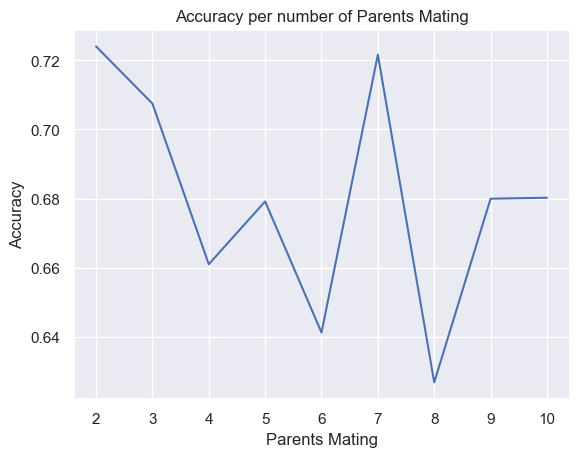

In [606]:
sns.set_theme();

plt.plot(accuracy_per_parents_mating[:,0], accuracy_per_parents_mating[:,1]);
plt.xlabel('Parents Mating');
plt.ylabel('Accuracy');
plt.title('Accuracy per number of Parents Mating');